In [21]:
from PIL import Image
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [16]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [17]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is not None:
        width = size.find('width').text
        height = size.find('height').text
        if width and height:
            return int(width), int(height)
    return 0, 0  


def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height


def parse_xml(xml_file, image_file_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    
    width, height = get_image_dimensions(xml_file, image_file_path)


    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Append the data to the dictionary
        data['filename'].append(filename)
        data['width'].append(width)
        data['height'].append(height)
        data['class'].append(obj_class)
        data['xmin'].append(xmin)
        data['ymin'].append(ymin)
        data['xmax'].append(xmax)
        data['ymax'].append(ymax)


In [18]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.transforms = transforms
        
        # Collect all image files (those ending in .jpg) and XML files
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        
        # Parse all corresponding XML files in the same directory
        for image_file in self.images:
            xml_file = image_file.replace('.jpg', '.xml')
            xml_path = os.path.join(data_dir, xml_file)
            image_path = os.path.join(data_dir, image_file)
            if os.path.exists(xml_path):
                parse_xml(xml_path, image_path)
        
        # After parsing, create a DataFrame for better handling of data
        self.dataframe = pd.DataFrame(data)

    def __len__(self):
        return len(self.images)
    
    def class_to_label(self, class_name):
        # Map class names to numerical labels
        class_mapping = {'apple': 1, 'banana': 2, 'orange': 3, 'mixed': 4}
        return class_mapping.get(class_name, 0)  # Return 0 for undefined classes
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.data_dir, image_name)
        
        # Read and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Find corresponding bounding boxes and labels from the DataFrame
        boxes = []
        labels = []
        
        # Filter the DataFrame to get bounding boxes for the current image
        image_data = self.dataframe[self.dataframe['filename'] == image_name]
        for _, row in image_data.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            label = self.class_to_label(row['class'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        
        # Albumentations expects boxes to be normalized in [0, 1]
        height, width = image.shape[:2]
        boxes = [[xmin / width, ymin / height, xmax / width, ymax / height] for xmin, ymin, xmax, ymax in boxes]
        
        # Apply transformations (if any)
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        # Convert to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        return image, target

In [20]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    ToTensorV2(p=1.0),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

dataset = FruitDataset(data_dir='/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/train_zip/train', transforms=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

for images, targets in dataloader:
    print(images[0].shape, targets[0]['boxes'])

torch.Size([3, 350, 700]) tensor([[0.3956, 0.0000, 0.9398, 1.0000]])
torch.Size([3, 768, 1024]) tensor([[0.3146, 0.2211, 0.6424, 0.6296],
        [0.0890, 0.3883, 0.9082, 0.7349],
        [0.0718, 0.5438, 0.9094, 0.9079]])
torch.Size([3, 263, 350]) tensor([[0.0229, 0.2319, 0.9914, 1.0000]])
torch.Size([3, 393, 600]) tensor([[0.4988, 0.2279, 0.9514, 0.9275],
        [0.0606, 0.1225, 0.5416, 0.8849]])
torch.Size([3, 450, 450]) tensor([[0.1519, 0.1660, 0.6567, 0.6565]])
torch.Size([3, 282, 426]) tensor([[0.1056, 0.2021, 0.5023, 0.7518],
        [0.3850, 0.1738, 0.7606, 0.7518],
        [0.5305, 0.0071, 0.8638, 0.5071]])
torch.Size([3, 640, 1024]) tensor([[0.0126, 0.3186, 0.2914, 0.7477],
        [0.6962, 0.4500, 0.9831, 0.9034],
        [0.5197, 0.3378, 0.7856, 0.7265],
        [0.2655, 0.3544, 0.5112, 0.7108]])
torch.Size([3, 336, 640]) tensor([[0.1875, 0.1339, 0.7516, 1.0000]])


libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 1394, 2091]) tensor([[0.2928, 0.0938, 0.5854, 0.8271]])
torch.Size([3, 450, 680]) tensor([[0.1376, 0.2069, 0.8728, 0.9124]])
torch.Size([3, 853, 1280]) tensor([[0.3029, 0.2385, 0.5518, 0.6140],
        [0.4479, 0.0852, 0.7180, 0.4395],
        [0.4395, 0.3757, 0.7248, 0.7098]])
torch.Size([3, 1225, 1300]) tensor([[0.2715, 0.2490, 0.9477, 0.9722]])
torch.Size([3, 374, 581]) tensor([[0.2478, 0.1230, 0.5852, 0.7781]])
torch.Size([3, 500, 500]) tensor([[0.2500, 0.3920, 0.5900, 0.7480],
        [0.3940, 0.2880, 0.7260, 0.6560]])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 386, 514]) tensor([[0.0321, 0.0051, 0.6582, 0.7396],
        [0.1846, 0.1576, 0.7149, 0.9308]])
torch.Size([3, 900, 1200]) tensor([[0.2362, 0.1983, 0.7522, 0.9245]])
torch.Size([3, 320, 600]) tensor([[0.0456, 0.0000, 0.5967, 0.9446]])
torch.Size([3, 500, 500]) tensor([[0.0000, 0.0693, 0.6880, 0.8131]])
torch.Size([3, 600, 600]) tensor([[0.1437, 0.0998, 0.9191, 0.8786]])
torch.Size([3, 320, 700]) tensor([[0.1236, 0.1451, 0.8035, 1.0000]])
torch.Size([3, 380, 500]) tensor([[0.4440, 0.0211, 0.9720, 0.7368]])
torch.Size([3, 416, 800]) tensor([[0.4275, 0.1995, 0.8763, 1.0000],
        [0.2200, 0.0938, 0.7675, 0.9183],
        [0.1625, 0.0192, 0.7437, 0.5433]])
torch.Size([3, 630, 1200]) tensor([[0.0000, 0.0232, 1.0000, 1.0000]])
torch.Size([3, 516, 800]) tensor([[0.3938, 0.4477, 0.6725, 0.8624],
        [0.1375, 0.4322, 0.4212, 0.8411],
        [0.3625, 0.5000, 0.8075, 0.8818]])
torch.Size([3, 480, 720]) tensor([[0.0375, 0.0375, 0.9097, 0.4000],
        [0.0181, 0.2208, 0.833

libpng warning: iCCP: known incorrect sRGB profile


In [22]:
def visualize_image_with_boxes(image, target):
    image_np = image.permute(1, 2, 0).numpy() * 255
    image_np = image_np.astype('uint8')

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    boxes = target["boxes"]
    labels = target["labels"]
    
    for i in range(boxes.shape[0]):
        box = boxes[i]
        label = labels[i].item()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"Label: {label}", color='white', fontsize=12, backgroundcolor='red')

    plt.show()

def visualize_some_images_with_boxes(dataloader, num_images=5):
    count = 0
    for images, targets in dataloader:
        for i in range(len(images)):
            visualize_image_with_boxes(images[i], targets[i])
            count += 1
            if count >= num_images:
                return

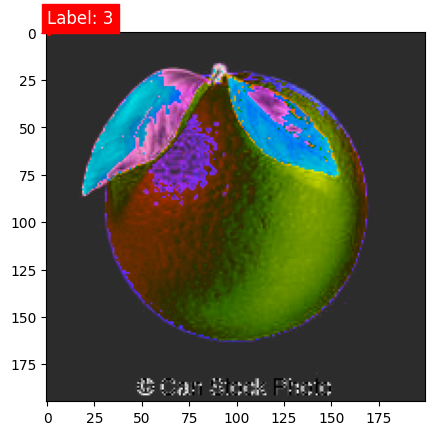

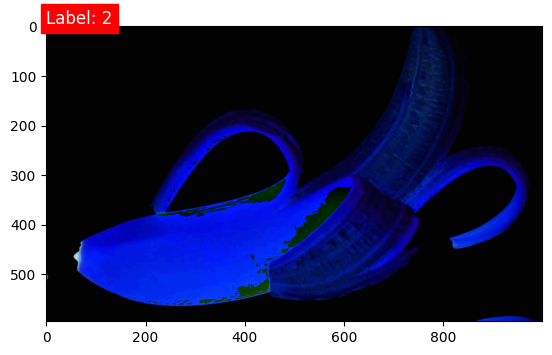

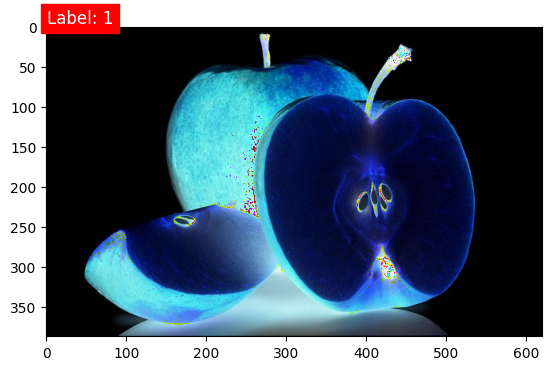

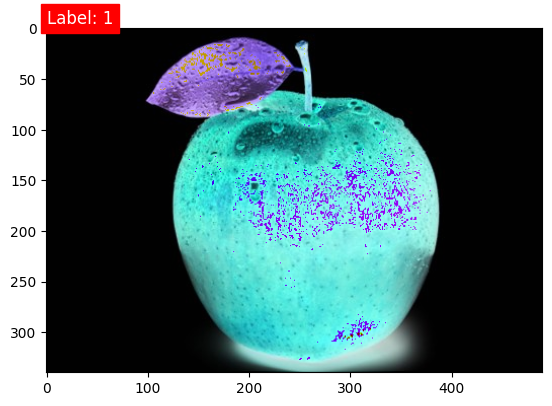

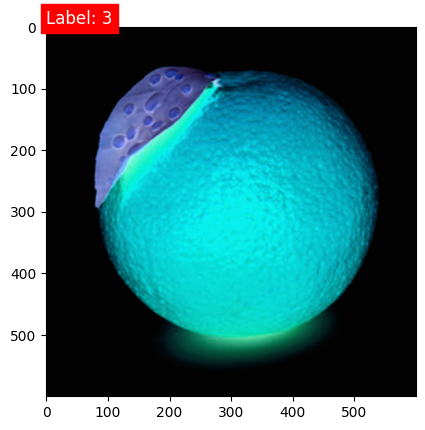

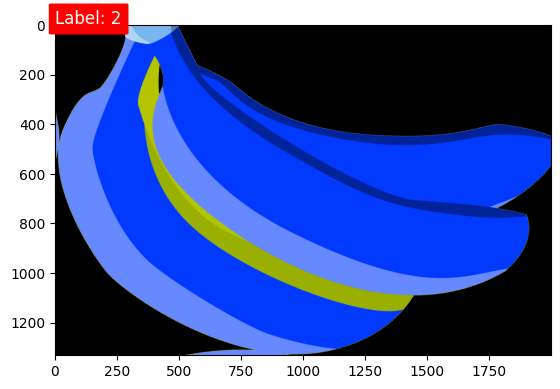

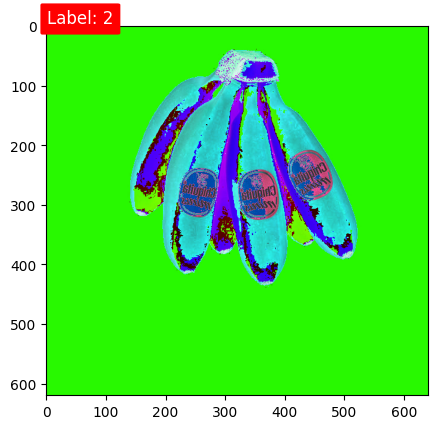

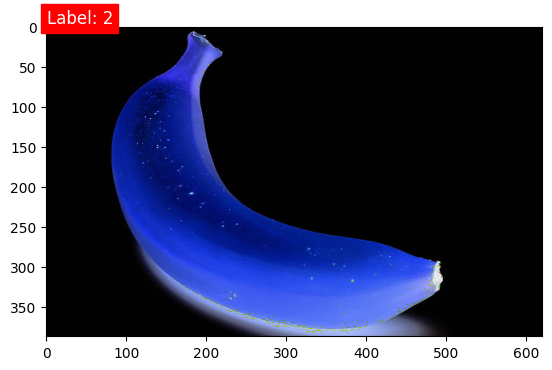

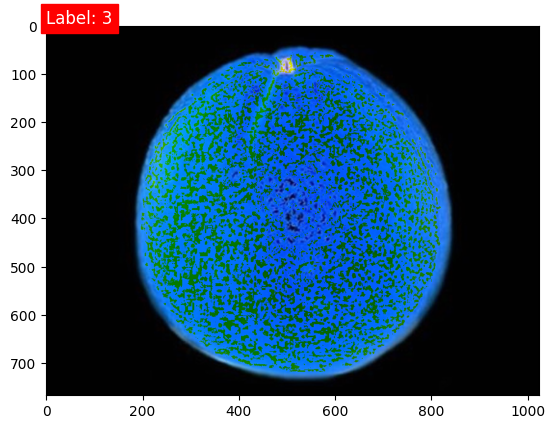

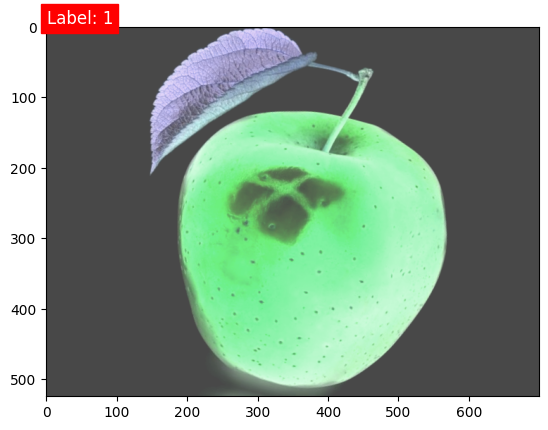

In [24]:
visualize_some_images_with_boxes(dataloader, num_images=10)